In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc
import pathlib
import os

import signac

from scipy import optimize

In [2]:
from monk import nb, prep, pair, render, utils, grid, workflow
import freud

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())

# mpl.rcParams["text.usetex"] = True
# mpl.rcParams["text.latex.preamble"].append(r'\usepackage{xfrac}')

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 2, 'dt': 0.005, 'step_unit': 1000, 'temp_steps': 20, 'equil_time': 40, 'run_time': 10, 'max_alpha_time': 1000, 'alpha_iters': 10, '_status': {}}

In [4]:
for job in project.find_jobs({"pot": "KA_LJ"}):
    files = sorted(glob.glob(job.fn("quench/*.gsd")))
    print(files)

['/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/quench/equil_temp-0.375.gsd', '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/quench/equil_temp-0.450.gsd', '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/quench/equil_temp-0.525.gsd', '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/quench/equil_temp-0.600.gsd', '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/quench/equil_temp-0.675.gsd', '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/quench/equil_temp-0.750.gsd', '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/quench/equil_temp-0.825.gsd', '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/quench/equil_temp-0.900.gsd', '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b/quench/equil_temp-0.975.gsd', '/media/ian/Data2/monk/2d-esl/workspace/a03bdc2a5be70a1e699a3f825fb8877b

In [13]:
def vis_snap_scatter(snap: gsd.hoomd.Snapshot, ax: Optional[plt.Axes] = None, zoom=None, c=None):

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    ax.clear()
    ax.set_aspect("equal")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xticks([])
    ax.set_yticks([])

    box = snap.configuration.box
    L = box[0]
    if zoom is not None:
        L /= zoom

    if c is None:
        ax.scatter(snap.particles.position[:, 0]/L, snap.particles.position[:, 1]/L, s=0.1)
    else:
        cmap = cm.jet
        norm = colors.Normalize(vmin=c.min(), vmax=c.max())
        ax.scatter(snap.particles.position[:, 0]/L, snap.particles.position[:, 1]/L, s=0.1, c=c, cmap=cmap, norm=norm)
        
    
    return ax


def vis_snap(snap: gsd.hoomd.Snapshot, ax: Optional[plt.Axes] = None, zoom=None, c=None):

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    ax.clear()
    ax.set_aspect("equal")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.set_xticks([])
    ax.set_yticks([])

    box = snap.configuration.box
    L = box[0]
    if zoom is not None:
        L /= zoom

    if c is None:
        ax.scatter(snap.particles.position[:, 0]/L, snap.particles.position[:, 1]/L, s=0.1)
    else:
        cmap = cm.jet
        norm = colors.Normalize(vmin=0.0, vmax=c.max())
        ax.scatter(snap.particles.position[:, 0]/L, snap.particles.position[:, 1]/L, s=0.1, c=c, cmap=cmap, norm=norm)
        
    
    return ax


In [14]:
traj = gsd.hoomd.open(files[-1])
snap = traj[0]
snap2 = traj[10]
box = freud.box.Box.from_box(snap.configuration.box)


In [15]:
diff = box.wrap(snap2.particles.position - snap.particles.position)
diff = np.linalg.norm(diff, axis=1)

<AxesSubplot:>

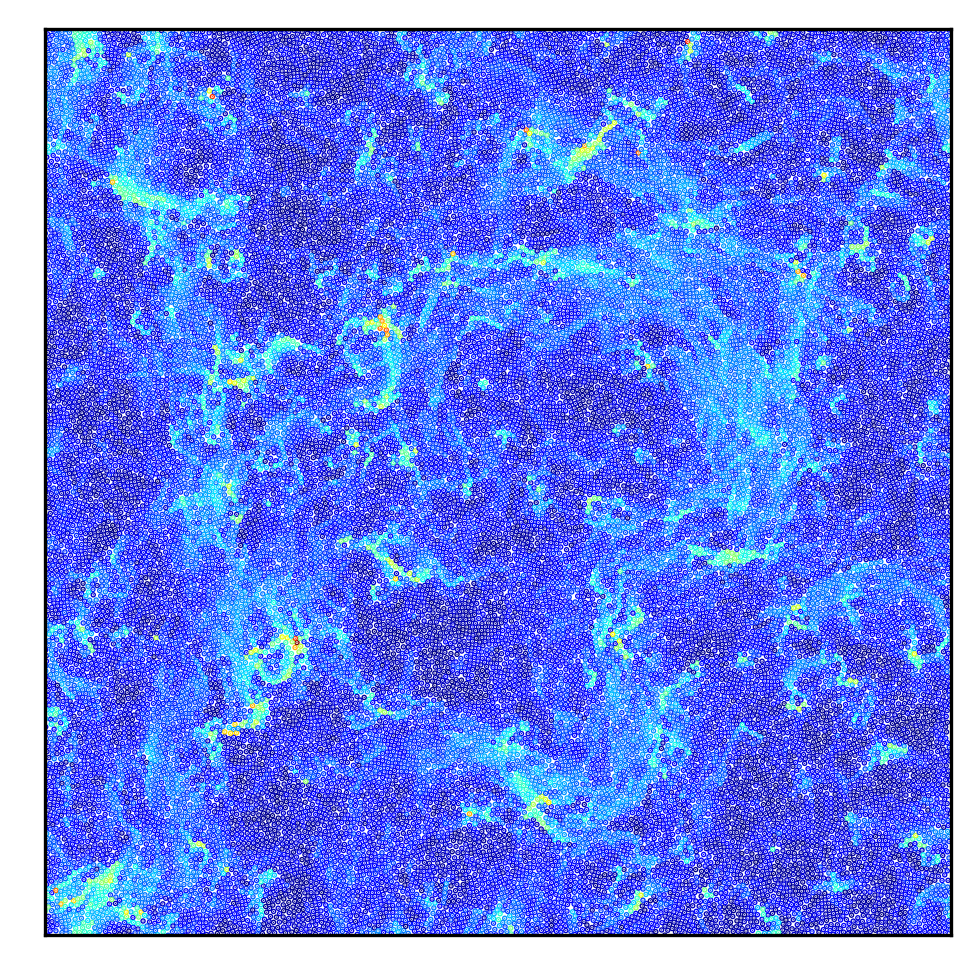

In [16]:
vis_snap(snap, zoom=2, c=diff)

In [17]:
len(traj)

61